# Gender Prediction by Speech Content

In [76]:
import joblib
import re
import string
import numpy as np
import random

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import imblearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = list(set(stopwords.words('german')))

In [54]:
# load data
df = pd.read_pickle('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/data_topics_revised.pkl')

df.head()

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
1,Herr Präsident! Liebe Kolleginnen und Kolleg...,2021-10-26,20,Stefan Müller,male,None,CDU/CSU,[(Beifall bei der CDU/CSU sowie bei Abgeordnet...,SP-2021-1,4028,3796,{68: 0.46776655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
3,Sehr geehrter Herr Präsident! Meine lieben K...,2021-10-26,20,Marco Buschmann,male,None,FDP,"[(Jan Korte [DIE LINKE]: Oder Jugendweihe!), (...",SP-2021-3,3083,4555,{}
4,Herr Alterspräsident! Lassen Sie mich zunäch...,2021-10-26,20,Stephan Brandner,male,None,AfD,"[(Beifall bei der AfD), (Beifall bei Abgeordne...",SP-2021-4,4055,5996,{68: 0.3120498}


In [55]:
df["speaker_gender"].value_counts()

speaker_gender
male      743167
female    228097
Name: count, dtype: int64

In [23]:
df.loc[8568].text

'  Sehr verehrte Frau Präsidentin! Meine Damen und Herren! „In dem Moment, in dem wir keine freie Presse mehr haben, kann alles passieren“, sagte Hannah Arendt 1974 in einem Interview. In dem Moment fehlt Wissen, und Journalistinnen und Journalisten leben gefährlich. Uninformiertheit war für Hannah Arendt ein Weg zum Totalitarismus und zur Unterdrückung. Folglich ist eine starke unabhängige Presse die Voraussetzung für das Funktionieren von Demokratie. Das galt 1974, und das gilt erst recht auch heute. Hannah Arendt setzte auf den einzelnen Menschen, auf seinen Willen, wissen zu wollen, auf seine Fähigkeit, selbst zu denken, auf Informationsfreiheit als Bollwerk gegen Diktaturen. Aus genau diesem Grund bekämpfen Diktaturen die freie Presse. „Reporter ohne Grenzen“ berichtet aktuell, dass so viele Journalistinnen und Journalisten in Haft sind wie noch niemals zuvor. 533 inhaftierte Journalistinnen und Journalisten sind ein neuer Negativrekord. Zwei Drittel sitzen ohne Verfahren ein. Auf

## Undersampling Male Speeches

In [30]:
# calculate topic ratios in original data
male_speeches_total = df['speaker_gender'].value_counts().male
female_speeches_total = df['speaker_gender'].value_counts().female

male_topic_ratios = {}

for topic in np.arange(0, 150):
    filtered_df = df[df['topic_distribution'].apply(lambda topics: topic in topics)]
    male_speeches = filtered_df.groupby('speaker_gender').size().male
    topic_ratio = male_speeches / male_speeches_total
    male_topic_ratios[topic] = topic_ratio

male_topic_ratios

In [32]:
# calculate new speech counts per topic for resampled data
new_speech_counts = {}

for topic, ratio in male_topic_ratios.items():
    new_speech_count = np.round(ratio * female_speeches_total)
    new_speech_counts[topic] = int(new_speech_count)

new_speech_counts

In [34]:
# assemble reduced male data
reduced_male_df = pd.DataFrame(columns=df.columns)

for topic, count in new_speech_counts.items():
    selected_speeches = df[(df['speaker_gender'] == 'male') & (df['topic_distribution'].apply(lambda topics: topic in topics))].head(count)
    
    reduced_male_df = pd.concat([reduced_male_df, selected_speeches], ignore_index=True)

C:\Users\Ana\AppData\Local\Temp\ipykernel_27892\332800175.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reduced_male_df = pd.concat([reduced_male_df, selected_speeches], ignore_index=True)


In [35]:
reduced_male_df

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,"Meine Damen und Herren! Herr Minister, ich m...",2021-11-11,20,Thomas Ehrhorn,male,None,AfD,"[(Beifall bei Abgeordneten der AfD), (Beifall ...",SP-2021-21,4132,982,{0: 0.22465643}
1,Ich möchte auf Ihre Frage gern antworten. Er...,2021-11-11,20,Olaf Scholz,male,Bundesminister der Finanzen,None,"[(Zuruf von der AfD: Warum?), (Beifall bei der...",SP-2021-22,3440,1951,"{0: 0.42684105, 29: 0.2142375}"
2,Sehr geehrte Frau Präsidentin! Meine Damen u...,2021-11-11,20,Sebastian Münzenmaier,male,None,AfD,[(Dr. Marco Buschmann [FDP]: Das ist Quatsch!)...,SP-2021-26,3961,4231,{0: 0.20533974}
3,"Ja, gerne. – Zunächst mal ist es ja ein Fort...",2021-11-18,20,Johannes Fechner,male,None,SPD,"[(Beifall bei der SPD, dem BÜNDNIS 90/DIE GRÜN...",SP-2021-98,2376,496,"{0: 0.24128607, 130: 0.25529233}"
4,Frau Präsidentin! Meine Damen und Herren! Da...,2021-11-18,20,Martin Sichert,male,None,AfD,[(Beifall bei Abgeordneten der AfD – Widerspru...,SP-2021-104,3216,6208,{0: 0.28747255}
...,...,...,...,...,...,...,...,...,...,...,...,...
261820,Ich rufe die Frage 89 des Abgeordneten Baier ...,1971-05-14,6,Kai-Uwe Von Hassel,male,Präsident,CDU,[],SP-1971-229919,2559,461,"{28: 0.29532668, 149: 0.27315643}"
261821,"Herr Kollege Baier, selbstverständlich respek...",1971-05-14,6,Heinz Westphal,male,Parlamentarischer Staatssekretär beim Bundesmi...,SPD,[],SP-1971-229920,1936,1451,"{61: 0.28843397, 86: 0.26967123, 149: 0.21287826}"
261822,"Herr Kollege Baier, Sie sind Mitglied des Hau...",1971-05-14,6,Heinz Westphal,male,Parlamentarischer Staatssekretär beim Bundesmi...,SPD,[],SP-1971-229923,1936,1164,"{107: 0.28058052, 149: 0.22335199}"
261823,"Herr Staatssekretär, ich verstehe Sie nicht, ...",1971-05-14,6,Fritz Baier,male,NA,CDU,[],SP-1971-229925,1243,475,{149: 0.36631507}


In [36]:
# remove duplicates due to multiple topics in one speech
to_remove = reduced_male_df[reduced_male_df['id'].duplicated() == True].index
reduced_male_df = reduced_male_df.drop(to_remove)

In [37]:
len(reduced_male_df['id'].unique())

200209

In [43]:
# test new ratios 
# male_speeches_total = reduced_male_df['speaker_gender'].value_counts().male
# #female_speeches_total = df['speaker_gender'].value_counts().female

# male_topic_ratios_new = {}

# for topic in np.arange(0, 150):
#     filtered_df = reduced_male_df[reduced_male_df['topic_distribution'].apply(lambda topics: topic in topics)]
#     #male_speeches = filtered_df.groupby('speaker_gender').size().male
#     topic_ratio = len(filtered_df) / male_speeches_total
#     male_topic_ratios_new[topic] = topic_ratio

# male_speeches_total

### Remove rest difference between male and female speeches

In [45]:
difference_count = df['speaker_gender'].value_counts().female - male_speeches_total
difference_count

27888

In [46]:
female_speeches = df[df['speaker_gender'] == 'female']

In [47]:
fem_indeces = list(female_speeches.index)

In [48]:
samples_to_remove = random.sample(fem_indeces, difference_count)
len(samples_to_remove)

27888

In [49]:
female_speeches = female_speeches.drop(samples_to_remove)

In [50]:
female_speeches

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution
0,Sehr geehrter Herr Alterspräsident! So muss ...,2021-10-26,20,Gabriele Katzmarek,female,None,SPD,[(Beifall bei der SPD sowie bei Abgeordneten d...,SP-2021-0,1299,2593,{68: 0.35882655}
2,Sehr geehrter Herr Alterspräsident Wolfgang ...,2021-10-26,20,Britta Haßelmann,female,None,BÜNDNIS 90/DIE GRÜNEN,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN und bei d...,SP-2021-2,451,4301,{68: 0.26328164}
7,"Herr Alterspräsident, vielen Dank. Ich nehme...",2021-10-26,20,Bärbel Bas,female,None,SPD,[(Beifall im ganzen Hause – Abgeordnete aller ...,SP-2021-7,471,89,{68: 0.7516313}
9,"Frau Präsidentin, ich nehme die Wahl sehr ge...",2021-10-26,20,Aydan Özoğuz,female,None,SPD,"[(Beifall bei der SPD, der CDU/CSU, dem BÜNDNI...",SP-2021-9,327,167,"{68: 0.37566105, 115: 0.4293458}"
10,"Ich nehme die Wahl an, bedanke mich auf das ...",2021-10-26,20,Yvonne Magwas,female,None,CDU/CSU,"[(Beifall bei der CDU/CSU, der SPD, dem BÜNDNI...",SP-2021-10,4708,188,{68: 0.38035467}
...,...,...,...,...,...,...,...,...,...,...,...,...
971274,"Ich weise noch einmal darauf hin, dass die Ze...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall beim BÜNDNIS 90/DIE GRÜNEN)],SP-2021-971274,3648,174,"{81: 0.2370022, 85: 0.5163264}"
971275,Sehr geehrte Frau Präsidentin! Meine Damen un...,2021-07-09,19,Britta Haßelmann,female,None,GRUENE,"[(Beifall beim BÜNDNIS 90/DIE GRÜNEN), (Beifal...",SP-2021-971275,451,1593,"{14: 0.25521588, 148: 0.345872}"
971276,Das Wort hat der Kollege Dr. Florian Toncar.,2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der FDP)],SP-2021-971276,3648,45,{}
971278,"Ich mache darauf aufmerksam, dass in fünf Min...",2021-07-09,19,Petra Pau,female,None,LINKE,[(Beifall bei der SPD und dem BÜNDNIS 90/DIE G...,SP-2021-971278,3648,10017,{52: 0.38018292}


### Combine to new resampled dataframe

In [51]:
resampled_data = pd.concat([reduced_male_df, female_speeches], ignore_index=True)

In [53]:
resampled_data["legislative_period"].value_counts().sort_values()

legislative_period
9      7139
20     9764
10    12559
15    12600
11    12608
12    14684
3     15914
8     16259
13    17533
2     18637
14    20683
17    21045
7     21656
16    21867
19    22214
18    23327
6     28020
1     28478
4     31501
5     43930
Name: count, dtype: int64

In [56]:
resampled_data[resampled_data["speaker_gender"] == "female"]["speech_length"].sum()

296099999

In [58]:
resampled_data[resampled_data["speaker_gender"] == "male"]["speech_length"].sum()

242973815

In [47]:
# test differences between original and new topic ratios
# np.subtract([*male_topic_ratios_new.values()], [*male_topic_ratios.values()])

array([0.00141626, 0.00259723, 0.00224538, 0.00105774, 0.0013889 ,
       0.00091286, 0.00163184, 0.00410218, 0.0023991 , 0.00137933,
       0.02460958, 0.00017801, 0.00298253, 0.00331147, 0.00054817,
       0.00027151, 0.00082235, 0.00364318, 0.00122518, 0.00151597,
       0.00110062, 0.00061719, 0.00093075, 0.00041942, 0.00212889,
       0.00074037, 0.00066248, 0.00476264, 0.00081071, 0.00315072,
       0.00257303, 0.00241748, 0.00057152, 0.00069848, 0.00014726,
       0.00058086, 0.0109106 , 0.00227023, 0.00291866, 0.00015569,
       0.00055272, 0.00109196, 0.00080768, 0.00056029, 0.00083511,
       0.00091645, 0.00104223, 0.00405231, 0.00192711, 0.00074563,
       0.00504063, 0.00020099, 0.00178553, 0.00112628, 0.00021807,
       0.000849  , 0.02167052, 0.00135837, 0.00432242, 0.00119771,
       0.00764887, 0.02195982, 0.00041031, 0.00660957, 0.00042738,
       0.00042344, 0.01087182, 0.00103284, 0.00616514, 0.00456327,
       0.00032315, 0.00124529, 0.00154018, 0.00513269, 0.00111

## Vectorize and Train Model

In [76]:
resampled_data = resampled_data[["speaker_gender", "text"]]
resampled_data

,speaker_gender,text
0,male,"Meine Damen und Herren! Herr Minister, ich m..."
1,male,Ich möchte auf Ihre Frage gern antworten. Er...
2,male,Sehr geehrte Frau Präsidentin! Meine Damen u...
3,male,"Ja, gerne. – Zunächst mal ist es ja ein Fort..."
4,male,Frau Präsidentin! Meine Damen und Herren! Da...
...,...,...
400413,female,Vielen Dank. – Frau Präsidentin! Meine sehr g...
400414,female,"Ich weise noch einmal darauf hin, dass die Ze..."
400415,female,Sehr geehrte Frau Präsidentin! Meine Damen un...
400416,female,Das Wort hat der Kollege Dr. Florian Toncar.


In [11]:
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())

    return text

In [64]:
resampled_data["clean_text"] = resampled_data.text.map(process_text)

In [65]:
resampled_data.head()

,text,date,legislative_period,speaker_name,speaker_gender,speaker_role,speaker_party,comments,id,speaker_id,speech_length,topic_distribution,clean_text
0,"Meine Damen und Herren! Herr Minister, ich m...",2021-11-11,20,Thomas Ehrhorn,male,None,AfD,"[(Beifall bei Abgeordneten der AfD), (Beifall ...",SP-2021-21,4132,982,{0: 0.22465643},meine damen und herren herr minister ich muss ...
1,Ich möchte auf Ihre Frage gern antworten. Er...,2021-11-11,20,Olaf Scholz,male,Bundesminister der Finanzen,None,"[(Zuruf von der AfD: Warum?), (Beifall bei der...",SP-2021-22,3440,1951,"{0: 0.42684105, 29: 0.2142375}",ich möchte auf ihre frage gern antworten erst ...
2,Sehr geehrte Frau Präsidentin! Meine Damen u...,2021-11-11,20,Sebastian Münzenmaier,male,None,AfD,[(Dr. Marco Buschmann [FDP]: Das ist Quatsch!)...,SP-2021-26,3961,4231,{0: 0.20533974},sehr geehrte frau präsidentin meine damen und ...
3,"Ja, gerne. – Zunächst mal ist es ja ein Fort...",2021-11-18,20,Johannes Fechner,male,None,SPD,"[(Beifall bei der SPD, dem BÜNDNIS 90/DIE GRÜN...",SP-2021-98,2376,496,"{0: 0.24128607, 130: 0.25529233}",ja gerne – zunächst mal ist es ja ein fortschr...
4,Frau Präsidentin! Meine Damen und Herren! Da...,2021-11-18,20,Martin Sichert,male,None,AfD,[(Beifall bei Abgeordneten der AfD – Widerspru...,SP-2021-104,3216,6208,{0: 0.28747255},frau präsidentin meine damen und herren dass i...


In [66]:
len(resampled_data)

400418

### Train Test Split

In [67]:
df_train, df_test = train_test_split(resampled_data, test_size=0.20, stratify=resampled_data.speaker_gender, random_state=0)

d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words=stop_words,
    min_df=50,
    max_df=0.4
)  

X_train = vec.fit_transform(df_train.clean_text)
X_test = vec.transform(df_test.clean_text)

y_train = df_train.speaker_gender
y_test = df_test.speaker_gender

In [69]:
import pickle

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_train.pkl', 'wb') as f:
#     pickle.dump(X_train, f)

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_test.pkl', 'wb') as f:
#     pickle.dump(X_test, f)

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_train.pkl', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_test.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

# load
with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_train.pkl', 'rb') as f:
   X_train = pickle.load(f)

with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/x_test.pkl', 'rb') as f:
   X_test = pickle.load(f)
    
with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_train.pkl', 'rb') as f:
   y_train = pickle.load(f)

with open('C:/Users/Ana/OneDrive - Hochschule Düsseldorf/MA/y_test.pkl', 'rb') as f:
   y_test = pickle.load(f)

In [70]:
X_test

<80084x81335 sparse matrix of type '<class 'numpy.int64'>'
	with 7025377 stored elements in Compressed Sparse Row format>

### Fit Model

In [86]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

preds = nb.predict(X_test)
print(classification_report(y_test, preds))

d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
d:\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
d:\anaconda3\Lib\site-packages\s

              precision    recall  f1-score   support

      female       0.89      0.71      0.79     40042
        male       0.76      0.91      0.83     40042

    accuracy                           0.81     80084
   macro avg       0.82      0.81      0.81     80084
weighted avg       0.82      0.81      0.81     80084



In [87]:
# save classifier and vectorizer
joblib.dump(nb, "nb.joblib")
joblib.dump(vec, "vec.joblib")

['vec.joblib']

In [6]:
# load
nb_saved = joblib.load("nb.joblib")
vec_saved = joblib.load("vec.joblib")

In [71]:
preds = nb_saved.predict(X_test)

In [90]:
y_test.value_counts()

speaker_gender
female    40042
male      40042
Name: count, dtype: int64

In [29]:
# test prediction
sample_text = ["Ich möchte Ihnen sagen, dass es schon gut gewesen wäre, wenn Sie ein paar Sätze zu dem haarsträubenden Verfahren – dem Riesendesaster und den zahlreichen Verfassungsverstößen – gesagt hätten, das wesentlich das Bundesfinanzministerium verursacht hat und das eine ratlose und planlose Regierung hinterlassen hat, die alle Hände voll zu tun hatte, die Fehler auszumerzen, die sie selber verursacht hat."]

clean_sample_text = process_text(sample_text)
sample_vec = vec_saved.transform(sample_text)
nb_saved.predict(sample_vec)

array(['male'], dtype='<U6')

## Confusion Matrix

In [91]:
confusion_matrix(y_test.to_numpy(), preds)

array([[28325, 11717],
       [ 3561, 36481]], dtype=int64)

<Axes: >

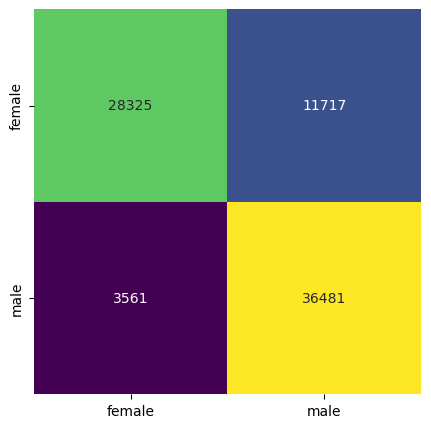

In [85]:
fig, ax = plt.subplots(figsize=(5, 5))

sb.heatmap(confusion_matrix(y_test.to_numpy(), preds),
           annot=True, cmap="viridis", cbar=False,
           fmt="d",
           xticklabels=nb_saved.classes_,
           yticklabels=nb_saved.classes_)

## Get Important Features

In [103]:
nb_saved.classes_

array(['female', 'male'], dtype='<U6')

In [106]:
vec_saved.get_feature_names_out()

array(['00', '00 uhr', '000', ..., 'übungen', 'ühlingen', 'üppig'],
      dtype=object)

In [97]:
fem_class_prob_sorted = nb_saved.feature_log_prob_[0, :].argsort()[::-1]
male_class_prob_sorted = nb_saved.feature_log_prob_[1, :].argsort()[::-1]

In [114]:
print("Important words in female speeches")
print(np.take(vec_saved.get_feature_names_out(), fem_class_prob_sorted[:20]))
print("-----------------------------------------")

print("Important words in male speeches")
print(np.take(vec_saved.get_feature_names_out(), male_class_prob_sorted[:20]))

Important words in female speeches
['dr' 'mehr' 'müssen' 'bundesregierung' 'frau' 'fraktion' 'schon'
 'menschen' 'frage' 'kollegen' 'heute' 'gibt' 'immer' 'ganz' 'sagen' 'ja'
 'kollege' 'wort' 'geht' 'herren']
-----------------------------------------
Important words in male speeches
['herren' 'frage' 'damen' 'damen herren' 'bundesregierung' 'worden'
 'kollege' 'muß' 'sagen' 'bitte' 'müssen' 'dr' 'mehr' 'antrag' 'heute'
 'herr kollege' 'schon' 'ja' 'deutschen' 'wort']
